In [1]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import accelerate  # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)
import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders

from torchvision.transforms import (  # Import image transformation functions
    Compose,  # Compose multiple image transformations
    CenterCrop,  # Center crop an image
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)


In [2]:
# Import the necessary module from the Python Imaging Library (PIL).
from PIL import ImageFile

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# Import necessary libraries
import os
from pathlib import Path
import pandas as pd

# Define dataset path (modify this to your actual dataset location)
dataset_path = Path("C:\\Users\\soham\\OneDrive\\Desktop\\ML PROJECT\\Dataset")  # Change this if needed

# Check if dataset path exists
if not dataset_path.exists():
    print(f"🚨 Dataset path '{dataset_path}' does not exist!")
else:
    print(f"✅ Dataset path exists: {dataset_path}")

# Initialize lists to store file paths and labels
file_names = []
labels = []

# Iterate through Train, Test, and Validation folders
for split in ["Train", "Test", "Validation"]:
    split_path = dataset_path / split  # Create path for each split (Train, Test, etc.)

    # Check if the split folder exists
    if not split_path.exists():
        print(f"🚨 Folder '{split}' not found!")
        continue

    # Iterate over Fake and Real subfolders
    for category in ["Fake", "Real"]:
        category_path = split_path / category  # Path to Fake/Real folders

        if not category_path.exists():
            print(f"🚨 Folder '{category}' inside '{split}' not found!")
            continue

        # Iterate over all image files in the category folder
        for file in category_path.glob("*.*"):  # Adjust glob if needed
            labels.append(category)  # Assign label based on folder name
            file_names.append(str(file))  # Store file path

# Print dataset summary
print(f"Total images found: {len(file_names)}")
print(f"Total labels found: {len(labels)}")

# Create a pandas dataframe
df = pd.DataFrame({"image": file_names, "label": labels})

# Display dataframe info
print(df.head())
print(f"Dataset shape: {df.shape}")


✅ Dataset path exists: C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dataset
Total images found: 190335
Total labels found: 190335
                                               image label
0  C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...  Fake
1  C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...  Fake
2  C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...  Fake
3  C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...  Fake
4  C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...  Fake
Dataset shape: (190335, 2)


In [4]:
# Import necessary libraries
from pathlib import Path
import pandas as pd

# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Define the dataset directory path
dataset_path = Path(r'C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dataset')

# Ensure the dataset path exists
if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset path '{dataset_path}' does not exist. Check the directory structure.")

# Iterate through all image files in the specified directory (recursively)
for file in sorted(dataset_path.glob('**/*.*')):  # Searches all subdirectories for files
    if file.is_file():  # Ensure it's a file, not a folder
        # Extract the label (folder name)
        label = file.parent.name if file.parent != dataset_path else "Unknown"
        labels.append(label)  # Add label to list
        file_names.append(str(file))  # Add file path to list

# Print the total number of file names and labels
print(f"Total images: {len(file_names)}, Total labels: {len(labels)}")

# Check if files were found
if len(file_names) == 0:
    raise ValueError("No image files found. Check if the dataset directory contains subfolders with images.")

# Create a pandas DataFrame from the collected file names and labels
df = pd.DataFrame({"image": file_names, "label": labels})
print("DataFrame shape:", df.shape)

# Display the first few rows to verify
print(df.head())


Total images: 190335, Total labels: 190335
DataFrame shape: (190335, 2)
                                               image label
0  C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...  Fake
1  C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...  Fake
2  C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...  Fake
3  C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...  Fake
4  C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...  Fake


In [5]:
df.head()

,image,label
0,C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...,Fake
1,C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...,Fake
2,C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...,Fake
3,C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...,Fake
4,C:\Users\soham\OneDrive\Desktop\ML PROJECT\Dat...,Fake


In [6]:
df['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [8]:
# random oversampling of minority class
# 'y' contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'label' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'label' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

print(df.shape)


(190402, 2)


In [9]:
# Create a dataset from a Pandas DataFrame.
# Converts a Pandas DataFrame to a Hugging Face Dataset:

# Dataset. from_pandas(df) creates a Hugging Face Dataset object from the Pandas DataFrame df.
# This is useful when transitioning from tabular data stored in a DataFrame to a Dataset for
# processing or training with Hugging Face tools.

# Casts the "image" Column to the Image Feature Type:

# .cast_column("image", Image()) modifies the Dataset by converting the data in the "image" column
# to a special feature type: Image.
# The Image() feature type allows the Hugging Face Dataset library to handle the column as image data.
# It supports loading and preprocessing images in a manner optimized for machine learning workflows.

dataset = Dataset.from_pandas(df).cast_column("image", Image())

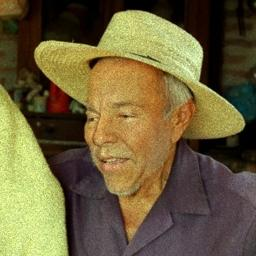

In [10]:
# Display the first image in the dataset
dataset[1] ["image"]

In [11]:
# Extracting a subset of elements from the 'labels' list using slicing.
# The slicing syntax [:5] selects elements from the beginning up to (but not including) the 5th element.
# This will give us the first 5 elements of the 'labels' list.
# The result will be a new list containing these elements.
labels_subset = labels [ : 5]

# Printing the subset of labels to inspect the content.
print(labels_subset)

['Fake', 'Fake', 'Fake', 'Fake', 'Fake']


In [12]:
# Create a list of unique labels by converting 'labels' to a set and then back to a list
labels_list = ['Real', 'Fake'] # list(set(labels))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label= dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i # Map the label to its corresponding ID
    id2label[i] = label # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [13]:
from datasets import load_dataset, ClassLabel, DatasetDict

# ✅ Load the dataset properly
dataset = load_dataset("C:/Users/soham/OneDrive/Desktop/ML PROJECT/Dataset")  # Replace with actual dataset name

# ✅ Extract labels and define ClassLabel object
labels = dataset["train"]["label"]
labels_list = [str(label) for label in set(labels)]  # Ensuring labels are strings

# ✅ Create ClassLabel object
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# ✅ Function to map labels to integers
def map_label2id(example):
    example["label"] = (
        [ClassLabels.str2int(label) if isinstance(label, str) else label for label in example["label"]]
        if isinstance(example["label"], list)  
        else ClassLabels.str2int(example["label"]) if isinstance(example["label"], str) else example["label"]
    )
    return example

# ✅ Apply label mapping
dataset = dataset.map(
    map_label2id,
    batched=True,
    batch_size=5,
    num_proc=1,
    keep_in_memory=False,
    load_from_cache_file=True
)

# ✅ Cast label column
dataset = dataset.cast_column("label", ClassLabels)

# ✅ Split the dataset properly
dataset_split = dataset["train"].train_test_split(test_size=0.3, shuffle=True, stratify_by_column="label")

# ✅ Convert back to DatasetDict
dataset = DatasetDict({
    "train": dataset_split["train"],
    "test": dataset_split["test"]
})

# ✅ Extract train & test datasets
train_data = dataset["train"]
test_data = dataset["test"]

# ✅ Debug: Print final structure
print("Train dataset sample:", train_data[0])
print("Test dataset sample:", test_data[0])


# # Creating classlabels to match labels to IDs
# ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# # Mapping labels to IDs
# def map_label2id(example):
#     example['label'] = ClassLabels.str2int(example['label'])
#     return example

# dataset = dataset.map(map_label2id, batched=True)

# # Casting label column to
# dataset = dataset. cast_column('label', ClassLabels)

# # Splitting the dataset into training and testing sets using an 60-40 split ratio.
# #dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")
# # Splitting the dataset into training and testing sets using a 60-40 split ratio.
# dataset_split = dataset["train"].train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# # Convert back to DatasetDict
# dataset = DatasetDict({
#     "train": dataset_split["train"],
#     "test": dataset_split["test"]
# })

# # Extracting the training data from the split dataset.
# train_data = dataset['train']

# # Extracting the testing data from the split dataset.
# test_data = dataset['test']


Train dataset sample: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x1B71D3AD2E0>, 'label': 0}
Test dataset sample: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x1B71D3AD2E0>, 'label': 0}


In [14]:
# Define the pre-trained ViT model string
model_str = "dima806/deepfake_vs_real_image_detection" # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
[
Resize((size, size)),  # Resize images to the ViT model's input size
RandomRotation(90),    # Apply random rotation
RandomAdjustSharpness(2),  # Adjust sharpness randomly
ToTensor(),     # Convert images to tensors
normalize    # Normalize images using mean and std
]
)


# Define a set of transformations for validation data
_val_transforms = Compose(
[
Resize((size, size)), # Resize images to the ViT model's input size
ToTensor(),  # Convert images to tensors
normalize   # Normalize images using mean and std
]
)



# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values' ] = [_train_transforms(image.convert("RGB")) for image in examples['image' ]]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image' ]]
    return examples



Size:  224


In [15]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)

In [16]:
# Define a collate function that prepares batched data for model trajining.
def collate_fn(examples):
# Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch. stack([example["pixel_values"] for example in examples])

# Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch. tensor([example['label'] for example in examples])

# Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

LOAD, TRAIN,  EVALUATE MODEL

In [17]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels
model = ViTForImageClassification. from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model. config. label2id = label2id

# Calculate and print the number of trainabsle parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)



85.800194


In [18]:
# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics'  to calculate evaluation metrics
def compute_metrics(eval_pred):
# Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy. compute(predictions=predicted_labels, references=label_ids) ['accuracy' ]

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
    "accuracy": acc_score
    }

In [19]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "deepfake_vs_real_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 2

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
# Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,

    # Specify the directory where training logs will be stored.
    logging_dir='./logs',

    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",

    # Set the learning rate for the optimizer.
    learning_rate=1e-6,

    # Define the batch size for training on each device.
    per_device_train_batch_size=32,

    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,

    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,

    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,

    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,

    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,

    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',

    # Load the best model at the end of training.
    load_best_model_at_end=True,

    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,

    # Specify that training progress should not be reported.
    report_to="none"
    )



In [20]:
# Create a Trainer instance for fine-tuning a language model.

# - 'model': The pre-trained language model to be fine-tuned.
# - 'args': Configuration settings and hyperparameters for training.
# - 'train_dataset': The dataset used for training the model.
# - 'eval_dataset': The dataset used for evaluating the model during training.
# - data_collator : A function that defines how data batches are collated and processed.
# - compute_metrics : A function for computing custom evaluation metrics.
# - 'tokenizer : The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor
)


In [19]:
#start training the model using trainer object
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.090600,0.079527,0.978389
2,0.078900,0.068513,0.980771


TrainOutput(global_step=8328, training_loss=0.2100301865312941, metrics={'train_runtime': 348322.7061, 'train_samples_per_second': 0.765, 'train_steps_per_second': 0.024, 'total_flos': 2.06491354886211e+19, 'train_loss': 0.2100301865312941, 'epoch': 2.0})

In [20]:
# Evaluate the post-training model's performance on the validation or test dataset.
# This function computes various evaluation metrics like accuracy, loss, etc.
# and provides insights into how well the model is performing.

trainer.evaluate()

{'eval_loss': 0.06851287931203842,
 'eval_accuracy': 0.9807709146950141,
 'eval_runtime': 10165.2926,
 'eval_samples_per_second': 5.617,
 'eval_steps_per_second': 0.702,
 'epoch': 2.0}

In [21]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(test_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 6.954702854156494, 'test_model_preparation_time': 0.004, 'test_accuracy': 0.007513003274898863, 'test_runtime': 16544.1631, 'test_samples_per_second': 3.451, 'test_steps_per_second': 0.431}


In [23]:
print(outputs)


PredictionOutput(predictions=array([[-3.9942834,  3.6927733],
       [ 3.7599142, -3.6293268],
       [-4.041391 ,  3.8093495],
       ...,
       [ 3.3647468, -3.2743683],
       [-3.993789 ,  3.7322924],
       [-3.9613929,  3.7808084]], shape=(57101, 2), dtype=float32), label_ids=array([0, 1, 0, ..., 1, 0, 0], shape=(57101,)), metrics={'test_loss': 6.954702854156494, 'test_model_preparation_time': 0.004, 'test_accuracy': 0.007513003274898863, 'test_runtime': 16544.1631, 'test_samples_per_second': 3.451, 'test_steps_per_second': 0.431})


First 10 True Labels: [0 1 0 0 1 0 1 0 1 1]
First 10 Predicted Labels: [0 1 0 0 1 0 1 0 1 1]
Accuracy: 0.9925
F1 Score: 0.9925


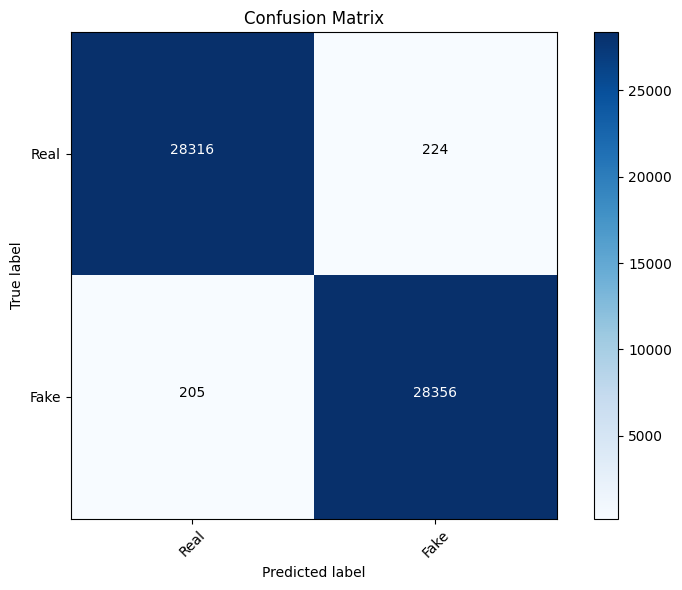


Classification Report:

              precision    recall  f1-score   support

        Real     0.9928    0.9922    0.9925     28540
        Fake     0.9922    0.9928    0.9925     28561

    accuracy                         0.9925     57101
   macro avg     0.9925    0.9925    0.9925     57101
weighted avg     0.9925    0.9925    0.9925     57101



In [27]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Extract true labels
y_true = outputs.label_ids  # Ground truth labels

# Extract predicted labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(axis=1)
# Correct the label inversion
y_pred = np.abs(y_pred - 1)  # Flip 0s to 1s and 1s to 0s


# Debugging: Print first few values to check alignment
print("First 10 True Labels:", y_true[:10])
print("First 10 Predicted Labels:", y_pred[:10])

# Define class labels
labels_list = ["Real", "Fake"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Calculate and display accuracy & F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
plot_confusion_matrix(cm, labels_list)

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))


In [25]:
# Print first few labels for debugging
print("First 20 True Labels:", y_true[:20])
print("First 20 Predicted Labels:", y_pred[:20])


First 20 True Labels: [0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0]
First 20 Predicted Labels: [1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1]


In [26]:
# Flip predicted labels
y_pred_flipped = np.abs(y_pred - 1)

# Recalculate accuracy
accuracy_flipped = accuracy_score(y_true, y_pred_flipped)
print(f"Accuracy After Flipping: {accuracy_flipped:.4f}")


Accuracy After Flipping: 0.9925


Accuracy: 0.0075
F1 Score: 0.0075


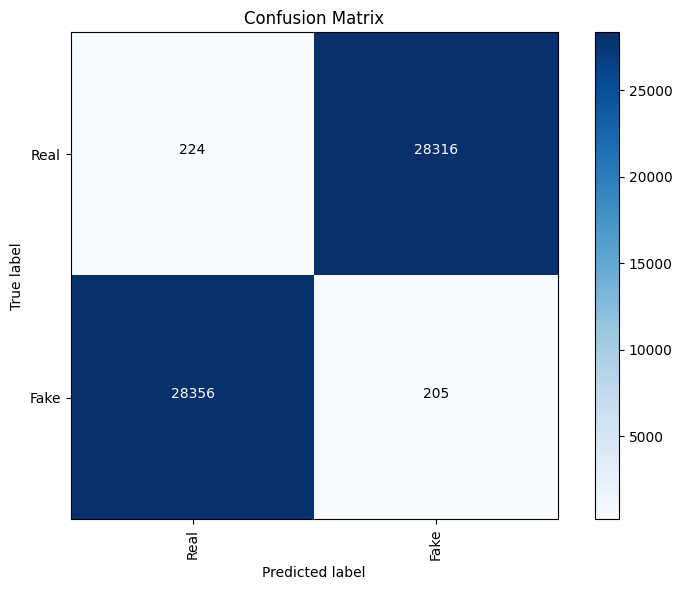


Classification report:

              precision    recall  f1-score   support

        Real     0.0078    0.0078    0.0078     28540
        Fake     0.0072    0.0072    0.0072     28561

    accuracy                         0.0075     57101
   macro avg     0.0075    0.0075    0.0075     57101
weighted avg     0.0075    0.0075    0.0075     57101



In [ ]:
#THISIS THE OG CODE BUT INCORRECT OP
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
# Create a figure with a specified size
    plt.figure(figsize=figsize)


    # Display the confusion matrix as an image with.a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)


    fmt = '.0f'
# Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot:
    plt.show()


# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy :.4f}")
print(f"F1 Score: {f1 :.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
# Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))


In [29]:
# Save the trained model: This line of code is responsible for saving the model
# that has been trained using the trainer object. It will serialize the model
# and its associated weights, making it possible to reload and use the model
# in the future without the need to retrain it.
trainer.save_model()

In [30]:
# Import the 'pipeline' function from the 'transformers' library.
from transformers import pipeline

# Create a pipeline for image classification tasks.
# You need to specify the 'model_name' and the 'device' to use for inference.
# - 'model_name': The name of the pre-trained model to be used for image classification.
# - 'device': Specifies the device to use for running the model (0 for GPU, -1 for CPU).
pipe = pipeline('image-classification', model=model_name, device=0)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [31]:
import shutil
# Replace 'your_folder_name' with the name of your folder
shutil.make_archive('deepfake_vs_real_image_detection', 'zip', 'deepfake_vs_real_image_detection' )

'c:\\Users\\soham\\OneDrive\\Desktop\\ML PROJECT\\Notebook\\deepfake_vs_real_image_detection.zip'